In [1]:

#Load training dataset
import sys
import numpy as np
import os
import matplotlib.pylab as plt

#Related functions.
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import official.nlp.modeling.layers as nlp_layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv1D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling1D
from tensorflow.keras.layers import Activation,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import openpyxl as op
from scipy.io import savemat,loadmat
import pickle#Use pickle to save model
from sklearn.utils import shuffle
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed
os.chdir(r'C:\Users\luhao\Dropbox\Federated_learning_diagnosis\PU_example_v3\Finalized_algorithms')
current_dir = os.path.dirname(os.path.abspath('__file__'))
os.path.dirname(current_dir)

data_path = os.path.dirname(os.path.dirname(os.path.dirname(current_dir)))+"\Code_for_bearing_diagnosis\Paderborn_case_study\data"

sys.path.append(os.path.dirname(current_dir)+"\Finalized_functions\\")

from StatisticsV2 import NormalDist
from Dataset_pre import *
from FedModels import *

In [2]:

SliceLen=1024# (Adopted from previous research, Each sample contains 0.08 s)
os.chdir(r'C:\Users\luhao\Dropbox\Code_for_bearing_diagnosis\Paderborn_case_study\Processed_PUdataset')

total_train_dataset=np.load('PUtraining_dataset_UB.npy',allow_pickle=True)
    

In [3]:
from sklearn.decomposition import PCA

pca= PCA(n_components =2)


tf.config.list_physical_devices('GPU')  
client_number=12
sample_len=512

batch_size = 128
num_classes = 3

num_hidden = 64
num_layers= 3
lr = 0.0005
lr_decay=0
comms_round = 25


In [4]:
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed

seed(666)
set_random_seed(666)
resnet_config = dict(num_classes=3, num_layers=num_layers, num_hidden=num_hidden)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = SGD(learning_rate=lr, 
    decay=lr_decay, 
    momentum=0.9
    )

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
local_model = DeepResNetSNGPWithCovReset(**resnet_config)
local_model.compile(**train_config)
local_model.build((None,sample_len))
# x_train_all=np.concatenate(total_train_dataset)[:,:-1]
# y_train_all=np.concatenate(total_train_dataset)[:,-1]
# local_model.fit(x_train_all,y_train_all,epochs=5)
model_weights = local_model.get_weights()

   
weight_list=[]
weight_list.append(model_weights)
gradhistory = []
losshistory = []

In [5]:
def recordweight(grads,loss_value):
    data = {}
    for g,w in zip(grads, local_model.trainable_weights):
        if '/kernel:' not in w.name:
            continue # skip bias
        name = w.name.split("/")[0]
        data[name] = g.numpy()
    gradhistory.append(data)
    losshistory.append(loss_value.numpy())

def Reshape_model_weights(Para):
    Par1=[]
    for i in range(len(Para)):
        Par1.append(Para[i].reshape(-1,1))
    Par1=np.concatenate(Par1)
    return Par1

# n_epochs=50
x_batch_train=total_train_dataset[0][:,:-1]
y_batch_train=total_train_dataset[0][:,-1]

def Record_Par_change(model,n_epochs,x_train,y_train):
    model_weights = local_model.get_weights()   
    weight_list=[]
    weight_list.append(model_weights)
    gradhistory = []
    losshistory = []
    for epoch in range(n_epochs):
        with tf.GradientTape() as tape:
            y_pred = local_model(x_batch_train, training=True)
            loss_value = loss(y_batch_train, y_pred)
        
        grads = tape.gradient(loss_value, local_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, local_model.trainable_weights))
        if epoch%5==0:
            # print(epoch)
            weight_list.append(local_model.get_weights())
            recordweight(grads,loss_value)
    Model_par=[]
    for weight in weight_list:
        Model_par.append(Reshape_model_weights(weight))
    Len_par=len(Model_par)
    Model_para=np.array(Model_par).reshape([Len_par,-1])
    return Model_para

n_epoch=25

In [6]:

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[0][:,:-1]
y_batch_train=total_train_dataset[0][:,-1]
Model1_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[1][:,:-1]
y_batch_train=total_train_dataset[1][:,-1]
Model2_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[2][:,:-1]
y_batch_train=total_train_dataset[2][:,-1]
Model3_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

#WC2
local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[3][:,:-1]
y_batch_train=total_train_dataset[3][:,-1]
Model4_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[4][:,:-1]
y_batch_train=total_train_dataset[4][:,-1]
Model5_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[5][:,:-1]
y_batch_train=total_train_dataset[5][:,-1]
Model6_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

#WC3
local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[6][:,:-1]
y_batch_train=total_train_dataset[6][:,-1]
Model7_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[7][:,:-1]
y_batch_train=total_train_dataset[7][:,-1]
Model8_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[8][:,:-1]
y_batch_train=total_train_dataset[8][:,-1]
Model9_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

#WC4
local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[9][:,:-1]
y_batch_train=total_train_dataset[9][:,-1]
Model10_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[10][:,:-1]
y_batch_train=total_train_dataset[10][:,-1]
Model11_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset[11][:,:-1]
y_batch_train=total_train_dataset[11][:,-1]
Model12_para=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)



In [7]:

#Create balanced dataset
#Combine all those togeather and /3
WC1_H=np.row_stack([total_train_dataset[0][np.where(total_train_dataset[0][:,-1]==0)[0]],
                    total_train_dataset[1][np.where(total_train_dataset[1][:,-1]==0)[0]],
                    total_train_dataset[2][np.where(total_train_dataset[2][:,-1]==0)[0]],
                    ])
WC1_I=np.row_stack([total_train_dataset[0][np.where(total_train_dataset[0][:,-1]==1)[0]],
                    total_train_dataset[1][np.where(total_train_dataset[1][:,-1]==1)[0]],
                    ])
WC1_O=np.row_stack([total_train_dataset[0][np.where(total_train_dataset[0][:,-1]==2)[0]],
                    total_train_dataset[2][np.where(total_train_dataset[2][:,-1]==2)[0]],
                    ])


ND_1=np.row_stack([WC1_H,WC1_I,WC1_O])


WC1_H=np.row_stack([total_train_dataset[3][np.where(total_train_dataset[3][:,-1]==0)[0]],
                    total_train_dataset[4][np.where(total_train_dataset[4][:,-1]==0)[0]],
                    total_train_dataset[5][np.where(total_train_dataset[5][:,-1]==0)[0]],
                    ])
WC1_I=np.row_stack([total_train_dataset[3][np.where(total_train_dataset[3][:,-1]==1)[0]],
                    total_train_dataset[4][np.where(total_train_dataset[4][:,-1]==1)[0]],
                    ])
WC1_O=np.row_stack([total_train_dataset[3][np.where(total_train_dataset[3][:,-1]==2)[0]],
                    total_train_dataset[5][np.where(total_train_dataset[5][:,-1]==2)[0]],
                    ])
H_len=len(WC1_H)//3
I_len=len(WC1_I)//3

ND_2=np.row_stack([WC1_H,WC1_I,WC1_O])


WC1_H=np.row_stack([total_train_dataset[6][np.where(total_train_dataset[6][:,-1]==0)[0]],
                    total_train_dataset[7][np.where(total_train_dataset[7][:,-1]==0)[0]],
                    total_train_dataset[8][np.where(total_train_dataset[8][:,-1]==0)[0]],
                    ])
WC1_I=np.row_stack([total_train_dataset[6][np.where(total_train_dataset[6][:,-1]==1)[0]],
                    total_train_dataset[7][np.where(total_train_dataset[7][:,-1]==1)[0]],
                    ])
WC1_O=np.row_stack([total_train_dataset[6][np.where(total_train_dataset[6][:,-1]==2)[0]],
                    total_train_dataset[8][np.where(total_train_dataset[8][:,-1]==2)[0]],
                    ])

ND_3=np.row_stack([WC1_H,WC1_I,WC1_O])


WC1_H=np.row_stack([total_train_dataset[9][np.where(total_train_dataset[9][:,-1]==0)[0]],
                    total_train_dataset[10][np.where(total_train_dataset[10][:,-1]==0)[0]],
                    total_train_dataset[11][np.where(total_train_dataset[11][:,-1]==0)[0]],
                    ])
WC1_I=np.row_stack([total_train_dataset[9][np.where(total_train_dataset[9][:,-1]==1)[0]],
                    total_train_dataset[10][np.where(total_train_dataset[10][:,-1]==1)[0]],
                    ])
WC1_O=np.row_stack([total_train_dataset[9][np.where(total_train_dataset[9][:,-1]==2)[0]],
                    total_train_dataset[11][np.where(total_train_dataset[11][:,-1]==2)[0]],
                    ])
ND_4=np.row_stack([WC1_H,WC1_I,WC1_O])


total_train_dataset2=[ND_1,ND_2,ND_3,ND_4]




local_model.set_weights(model_weights)
x_batch_train=total_train_dataset2[0][:,:-1]
y_batch_train=total_train_dataset2[0][:,-1]
Model1_p=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset2[1][:,:-1]
y_batch_train=total_train_dataset2[1][:,-1]
Model2_p=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

local_model.set_weights(model_weights)
x_batch_train=total_train_dataset2[2][:,:-1]
y_batch_train=total_train_dataset2[2][:,-1]
Model3_p=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)

#WC2
local_model.set_weights(model_weights)
x_batch_train=total_train_dataset2[3][:,:-1]
y_batch_train=total_train_dataset2[3][:,-1]
Model4_p=Record_Par_change(local_model,n_epoch,x_batch_train,y_batch_train)



pca.fit(np.row_stack([Model1_para,Model2_para,Model3_para,
                      Model4_para,Model5_para,Model6_para,
                      Model7_para,Model8_para,Model9_para,
                      Model10_para,Model11_para,Model12_para,
                      Model1_p,Model2_p,Model3_p,
                      Model4_p]))


Transformed_p1=pca.transform(Model1_p)
Transformed_p2=pca.transform(Model2_p)
Transformed_p3=pca.transform(Model3_p)
Transformed_p4=pca.transform(Model4_p)






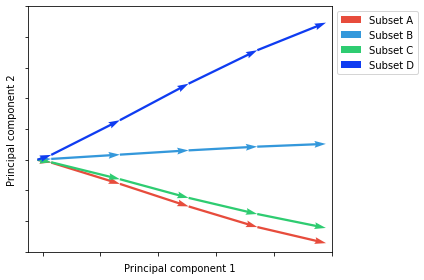

In [8]:

color_dic_unit=['#E74C3C',
                '#3498DB',
                '#2ECC71',
                '#0f3cf1',
                ]

#Training with balanced dataset. (and combined togeather)
fig, ax = plt.subplots()
x=Transformed_p1[:,0]
y=Transformed_p1[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[0])

x=Transformed_p2[:,0]
y=Transformed_p2[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[1])

x=Transformed_p3[:,0]
y=Transformed_p3[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[2])

x=Transformed_p4[:,0]
y=Transformed_p4[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[3])

plt.legend(['Subset A','Subset B','Subset C','Subset D'],loc="upper left", bbox_to_anchor=(1,1),ncol=1)
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_xlim([-250000,800000])
ax.set_ylim([-30000,50000])
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.tight_layout()



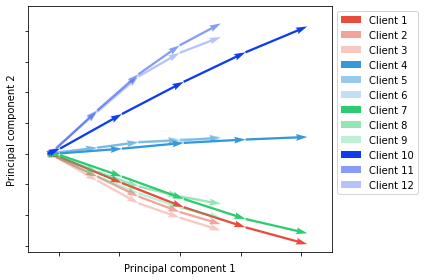

In [9]:

Transformed_para1=pca.transform(Model1_para)
Transformed_para2=pca.transform(Model2_para)
Transformed_para3=pca.transform(Model3_para)

Transformed_para4=pca.transform(Model4_para)
Transformed_para5=pca.transform(Model5_para)
Transformed_para6=pca.transform(Model6_para)

Transformed_para7=pca.transform(Model7_para)
Transformed_para8=pca.transform(Model8_para)
Transformed_para9=pca.transform(Model9_para)

Transformed_para10=pca.transform(Model10_para)
Transformed_para11=pca.transform(Model11_para)
Transformed_para12=pca.transform(Model12_para)


#Training with Old setting



fig, ax = plt.subplots()

x=Transformed_para1[:,0]
y=Transformed_para1[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[0])
x=Transformed_para2[:,0]
y=Transformed_para2[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[0],alpha=0.5,ls='dashed')
x=Transformed_para3[:,0]
y=Transformed_para3[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[0],alpha=0.3,ls='--')



x=Transformed_para4[:,0]
y=Transformed_para4[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[1])
x=Transformed_para5[:,0]
y=Transformed_para5[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[1],alpha=0.5,ls='-.')
x=Transformed_para6[:,0]
y=Transformed_para6[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[1],alpha=0.3,ls='--')


x=Transformed_para7[:,0]
y=Transformed_para7[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[2])
x=Transformed_para8[:,0]
y=Transformed_para8[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[2],alpha=0.5,ls='-.')
x=Transformed_para9[:,0]
y=Transformed_para9[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[2],alpha=0.3,ls='--')

x=Transformed_para10[:,0]
y=Transformed_para10[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[3])

x=Transformed_para11[:,0]
y=Transformed_para11[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[3],alpha=0.5,ls='-.')

x=Transformed_para12[:,0]
y=Transformed_para12[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,color=color_dic_unit[3],alpha=0.3,ls='--')

plt.legend(['Client 1','Client 2','Client 3',
            'Client 4','Client 5','Client 6',
            'Client 7','Client 8','Client 9',
            'Client 10','Client 11','Client 12',],loc="upper left", bbox_to_anchor=(1,1),ncol=1)

ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_xlim([-250000,250000])
ax.set_ylim([-8000,12000])
plt.tight_layout()
